# Continuous Control

---

In this notebook, we use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from collections import deque
from datetime import datetime
import numpy as np
from pathlib import Path
from unityagents import UnityEnvironment
from uuid import uuid4

import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import DDPGAgent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33


### 3. Training Functions

In [5]:
def save_data(agent, name, scores):
    now = datetime.now().strftime('%Y-%m-%d_%H%M')
    train_name = 'train_{}_{}'.format(name, now)
    train_dir = Path(train_name)
    train_dir.mkdir(exist_ok=True)

    actor_local_path = train_dir / 'checkpoint_actor_local_{}.pth'.format(train_name)
    actor_target_path = train_dir / 'checkpoint_actor_target_{}.pth'.format(train_name)
    critic_local_path = train_dir / 'checkpoint_critic_local_{}.pth'.format(train_name)
    critic_target_path = train_dir / 'checkpoint_critic_target_{}.pth'.format(train_name)
    agent.save(actor_local_path, actor_target_path,
               critic_local_path, critic_target_path)

    logfile = train_dir / "score_{}.csv".format(train_name)
    rows = ["{},{}".format(i+1, v) for i, v in enumerate(scores)]
    score_csv = ["episode,score"] + rows
    with logfile.open(mode='w') as f:
        f.write('\n'.join(score_csv))

def ddpg(env, agent, n_episodes=1000):
    train_id = str(uuid4())[:8]

    scores = []
    scores_window = deque(maxlen=100)

    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        num_agents = len(env_info.agents)
        states = env_info.vector_observations
        agent.reset()

        episode_scores = np.zeros(num_agents)

        # run the episode
        done = False
        while not done:
            actions = np.array([agent.act(states[i]) for i in range(num_agents)])

            # send the actions to the environment
            env_info = env.step(actions)[brain_name]

            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            experiences = zip(states, actions, rewards, next_states, dones)
            for state, action, reward, next_state, done in experiences:
                agent.step(state, action, reward, next_state, done)

            episode_scores += rewards
            states = next_states
            done = np.any(dones)

        m_scores = np.mean(episode_scores)
        scores_window.append(m_scores)
        scores.append(m_scores)

        msg = '\rEpisode {}\tAverage Score (over agents): {:.2f}\tAverage Score (over last 100 episodes): {:.2f}'
        print(msg.format(i_episode, m_scores, np.mean(scores_window)), end="")

        if i_episode % 10 == 0:
            print(msg.format(i_episode, m_scores, np.mean(scores_window)))

        if np.mean(scores_window) > 10.0:
            name = '{}_ep_{}'.format(train_id, i_episode)
            save_data(agent, name, scores)

        if np.mean(scores_window) >= 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            name = '{}_solved'.format(train_id)
            save_data(agent, name, scores)
            break

    return scores

### 4. Hyperparameters

In [6]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

UPDATE_EVERY = 20
UPDATE_TIMES = 10

### 5. Instantiate the Agent


In [7]:
agent = DDPGAgent(
    state_size, 
    action_size, 
    random_seed=0,
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,
    gamma=GAMMA,
    tau=TAU,
    lr_actor=LR_ACTOR,
    lr_critic=LR_CRITIC,
    weight_decay=WEIGHT_DECAY,
    update_every=UPDATE_EVERY,
    update_times=UPDATE_TIMES
)

### 6. Train the Agent with DDPG


In [8]:
scores = ddpg(env, agent)

Episode 10	Average Score (over agents): 7.18	Average Score (over last 100 episodes): 3.73
Episode 20	Average Score (over agents): 8.60	Average Score (over last 100 episodes): 6.733
Episode 30	Average Score (over agents): 11.44	Average Score (over last 100 episodes): 8.14
Episode 40	Average Score (over agents): 12.05	Average Score (over last 100 episodes): 9.33
Episode 50	Average Score (over agents): 14.78	Average Score (over last 100 episodes): 10.18
Episode 60	Average Score (over agents): 15.36	Average Score (over last 100 episodes): 11.00
Episode 70	Average Score (over agents): 15.07	Average Score (over last 100 episodes): 11.72
Episode 80	Average Score (over agents): 17.78	Average Score (over last 100 episodes): 12.40
Episode 90	Average Score (over agents): 16.88	Average Score (over last 100 episodes): 12.93
Episode 100	Average Score (over agents): 18.25	Average Score (over last 100 episodes): 13.49
Episode 110	Average Score (over agents): 20.38	Average Score (over last 100 episodes

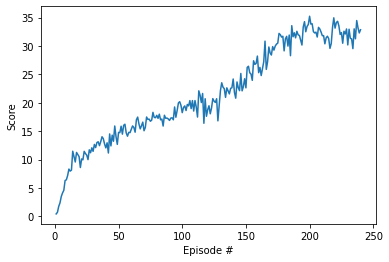

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, close the environment.

In [10]:
env.close()